**Basics with CV2**

In [1]:
%matplotlib inline

In [2]:
import cv2, matplotlib.pyplot as plt

# CONSIDER THE USE OF cv2 imread function
# this converts an image into array of pixel values
img = cv2.imread("resources/image.jpg")
type(img)

numpy.ndarray

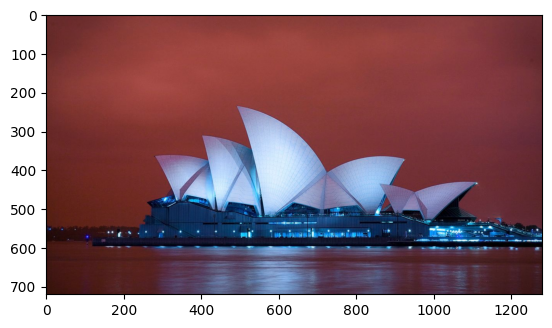

In [3]:
plt.imshow(img)

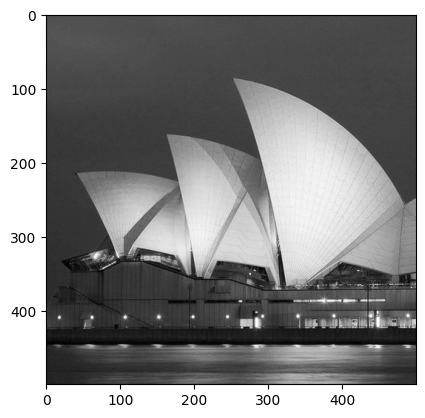

In [4]:
img = img[150:650, 240:740]
img_in_grey = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.imshow(img_in_grey,cmap='gray')

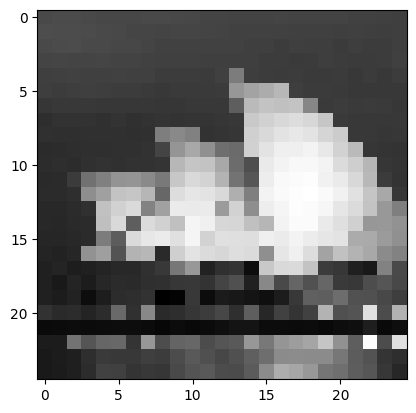

In [5]:
img_in_grey_small = cv2.resize(img_in_grey,(25,25))
plt.imshow(img_in_grey_small,cmap='gray')

**Start writting torchvision codes**

In [ ]:
from torchvision import datasets
import torch
import os 

data_folder = os.getcwd() + "/data/FMNIST"
fmnist = datasets.FashionMNIST(data_folder,download= True,train=True)

In [7]:
tr_images = fmnist.data 
tr_targets = fmnist.targets

In [8]:
unique_values = tr_targets.unique()
print(f'tr_images & tr_targets:\n\tX -{tr_images.shape}\n\tY \
-{tr_targets.shape}\n\tY-Unique Values : {unique_values}')
print(f'TASK:\n\t{len(unique_values)} class Classification')
print(f'UNIQUE CLASSES:\n\t{fmnist.classes}')

tr_images & tr_targets:
	X -torch.Size([60000, 28, 28])
	Y -torch.Size([60000])
	Y-Unique Values : tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
TASK:
	10 class Classification
UNIQUE CLASSES:
	['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


C:\Users\MASOUD\AppData\Local\Temp\ipykernel_3116\2150553229.py:11: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


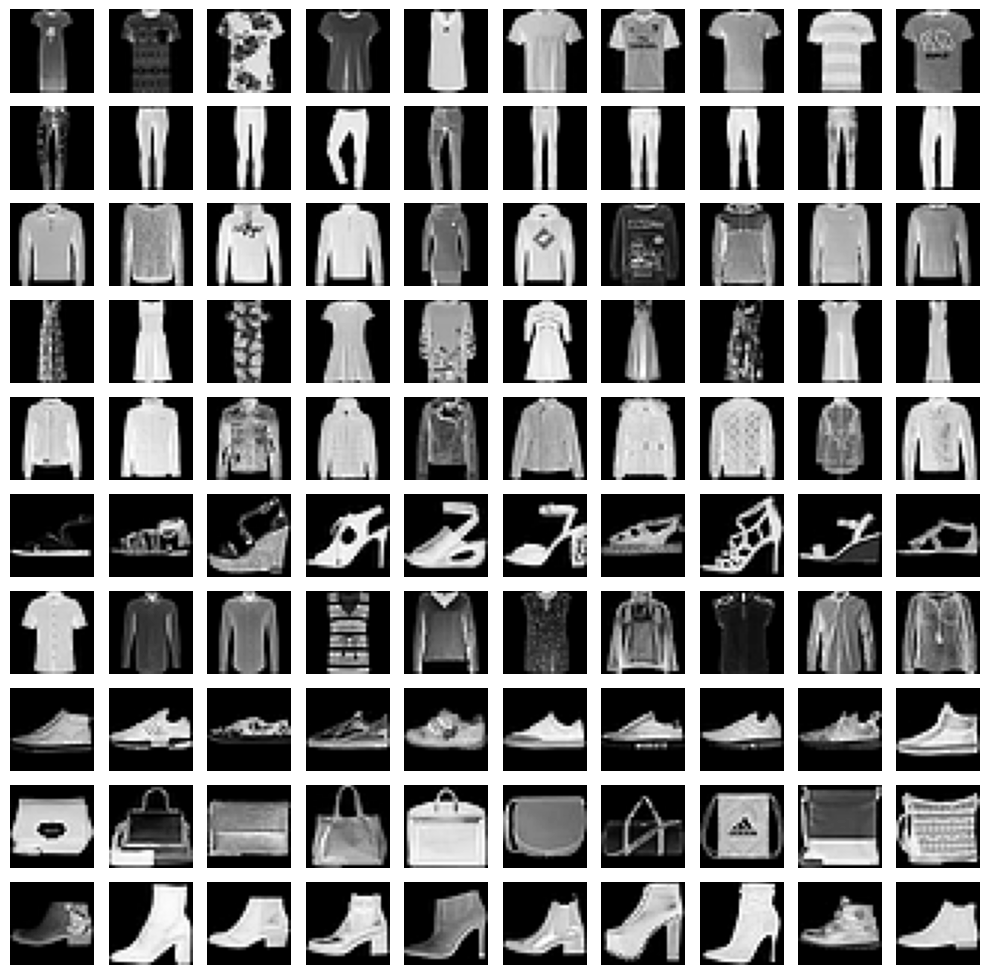

In [10]:
import numpy as np
R, C = len(tr_targets.unique()), 10
fig, ax = plt.subplots(R, C, figsize=(10,10))
for label_class, plot_row in enumerate(ax):
    label_x_rows = np.where(tr_targets == label_class)[0]
    for plot_cell in plot_row:
        plot_cell.grid(False); plot_cell.axis('off')
        ix = np.random.choice(label_x_rows)
        x, y = tr_images[ix], tr_targets[ix]
        plot_cell.imshow(x, cmap='gray')
    plt.tight_layout()

**Build Neural Network**

In [31]:
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline
device = "cuda" if torch.cuda.is_available()else "cpu"
from torchvision import datasets
data_folder = os.getcwd()+"/data/FMNIST"
fmnist = datasets.FashionMNIST(data_folder,train=True,download=True)
tr_images = fmnist.data
tr_targets = fmnist.targets


val = datasets.FashionMNIST(data_folder,train=False,download=True)
val_images = val.data
val_targets = val.targets

*Define Dataset Class*

In [15]:
class FMNISTDataset(Dataset):
    def __init__(self,x,y):
        x = x.float()/255  #scaling input is done in Dataset class
        x = x.view(-1,28*28)
        self.x ,self.y= x,y

    def __getitem__(self, ix):
        x,y = self.x[ix],self.y[ix]
        return x.to(device),y.to(device)
    
    def __len__(self):
        return len(self.x)

*Define Data Loader*

In [33]:
def get_data():
    train = FMNISTDataset(tr_images,tr_targets) #transforms tr_images to 28*28 arrays in __init__
    train_dl = DataLoader(train, batch_size=32,shuffle=True) #calls __getitem__ witch takes tensors into appropriate device
    
    validate = FMNISTDataset(val_images,val_targets) #transforms tr_images to 28*28 arrays in __init__
    val_dl = DataLoader(validate, len(val_images),shuffle=True) #calls __getitem__ witch takes tensors into appropriate device
    
    
    
    
    return train_dl,val_dl

*Define Model*

In [30]:
from torch.optim import SGD
def get_model():
    model = nn.Sequential(
        nn.Linear(28*28,1000),
        nn.BatchNormal(),
        nn.ReLU(),
        nn.Linear(1000,10)
    )
    loss_fn = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(),lr=1e-3)
    return model, loss_fn, optimizer

*Define Training Function*

In [18]:
def train_model(x,y,model,loss_fn,optimizer):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction,y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

*validation by calculating loss function*

In [36]:
@torch.no_grad
def val_loss(x,y,model):
    model.eval()
    prediction = model(x)
    val_loss = loss_fn(prediction,y)
    return val_loss.item()

*Evaluation Phase*

In [19]:
@torch.no_grad
def get_evaluation(x,y,model):
    model.eval()
    prediction = model(x)
    max_value, argmax = prediction.max(-1)
    is_correct = argmax == y
    return is_correct.cpu().numpy().tolist()

In [21]:
trn_dl = get_data()
model,loss_fn,optimizer = get_model()


In [37]:
losses,accuracies = [],[]
validate_losses, validate_accuracies = [],[]

*Training Model*

In [40]:
for epoch in range(5):
    print(epoch)
    epoch_losses , epoch_accuracies = [],[]
    
    for ix, batch in enumerate(iter(trn_dl)):
        x,y = batch
        batch_loss = train_model(x,y,model,loss_fn,optimizer)
        epoch_losses.append(batch_loss)
    epoch_loss = np.array(epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x,y = batch
        is_correct = get_evaluation(x,y,model)
        epoch_accuracies.extend(is_correct)
    epoch_accuracy = np.mean(epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = get_evaluation(x, y, model)
        validation_loss = val_loss(x, y, model)
        val_epoch_accuracy = np.mean(val_is_correct)

    losses.append(epoch_loss)
    accuracies.append(epoch_accuracy)
    validate_losses.append(validation_loss)
    validate_accuracies.append(val_epoch_accuracy)

0
1
2
3
4


C:\Users\MASOUD\AppData\Local\Temp\ipykernel_5612\1939176476.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


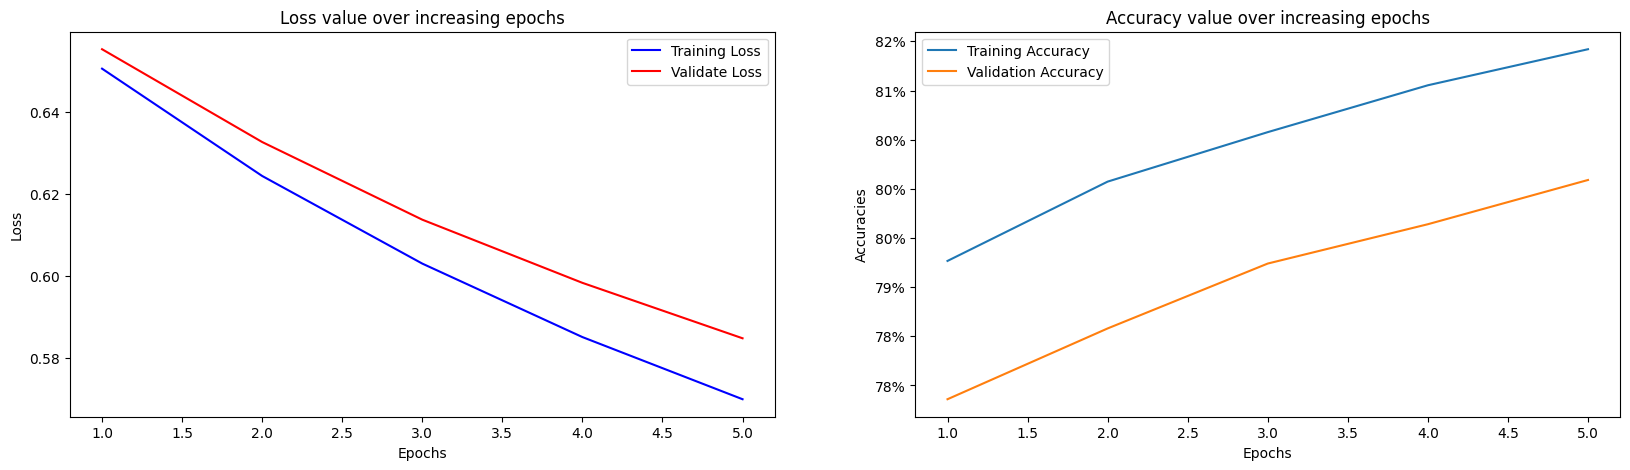

In [45]:
epochs = np.arange(5)+1
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('Loss value over increasing epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(epochs, losses,'b', label='Training Loss')
plt.plot(epochs, validate_losses,'r', label='Validate Loss')
plt.legend()

plt.subplot(122)
plt.title('Accuracy value over increasing epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracies')
plt.plot(epochs, accuracies, label='Training Accuracy')
plt.plot(epochs, validate_accuracies, label='Validation Accuracy')

plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.legend()

In [44]:
accuracies

[0.7926666666666666,
 0.8007333333333333,
 0.8057666666666666,
 0.8105333333333333,
 0.8142]

In [15]:
hi

0.25

In [16]:

hi = np.mean([1,1,2,3,5])

In [17]:
hi

2.4